In [2]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import random

# CLUSTERING

<b>Unsupervised Learning: </b> Se usa con la ausencia de un atributo objetivo. Es una forma de modelar la estructura que se encuentra dentro de los atributos descriptivos. <p>
Su procedimento desprende nuevas features que pueden ser agregadas al dataset original para aumentarlo o enriquecerlo
<p>
Cabe destacar que suele ser usado como objetivo final (armar los clusters) o como input para modelos de supervised learning.

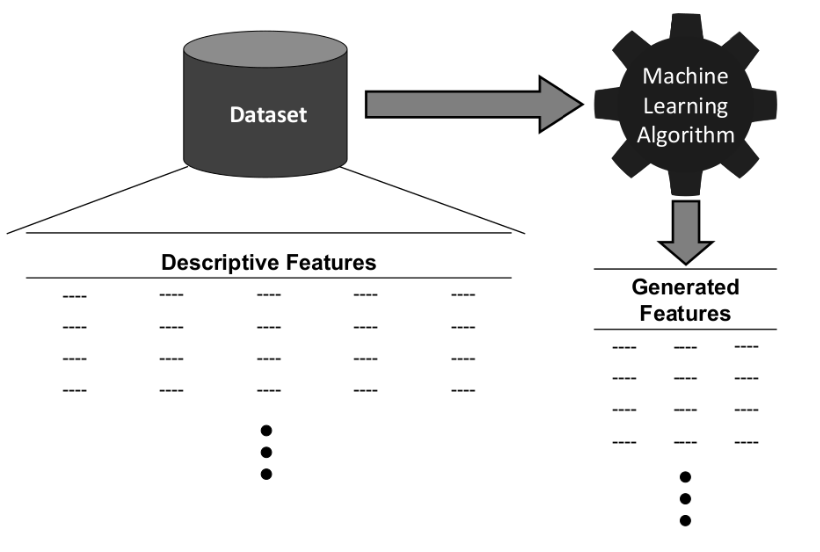

<b> Clustering:</b>  es una técnica que particiona los datos en grupos o "clusters" observando similitudes en los datos. El procedimiento finaliza con un nuevo atributo que indíca a que cluster pertenece cada instancia del dataset. <p>
Clustering es muy usado por ejemplo en segmentación de mercado donde se busca grupos signficantes como target para la venta de un producto

## K-Means

<b> K-means </b> es el proceso mas estandár de clusterización
<p>
    A partir de un dataset <b> D </b> que consiste de <b> n </b> filas con <b> m </b> atributos y un número <b> k </b> buscamos agrupar los datos en <b> k </b> grupos distintos <b> C1, C2 .... Ck </b> 

### Cómo funciona

Cada grupo  <b> C1, C2 .... Ck </b>  posee centroides <b> c1, c2, ... ck </b> que son los puntos del centro de cada cluster utilizando una medida elegida por nosotros (con ciertas restricciónes de convergencia) denominda <b> dist </b>

Busca una agrupación de los datos tal de minimizar la  suma de todas las distancias de los  datos de entrenamiento a sus respectivos centroides usando al medida dist
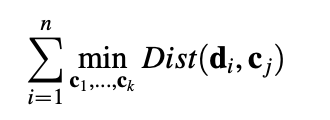

Es importante tener en cuenta que las feautres esten normalizadas con el objetivo de poder comparar la contribución de cada una al proceso de clusterización

### Procedimiento

Primero definamos los inputs: <b> K, Dataset, Dist </b>

In [3]:
K = 3

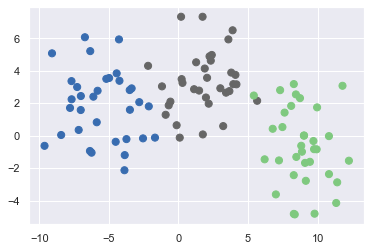

In [4]:
data, y = make_blobs(n_samples=100, n_features=2, centers=K, random_state=37, cluster_std=2)
plt.scatter(data[:, 0], data[:, 1], c=y, s=50, cmap='Accent');

Generamos un dataset normalizado:

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

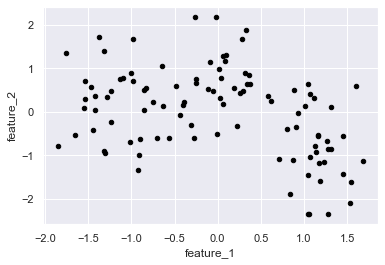

In [6]:
normalized_df=(df-df.mean())/df.std()
normalized_df.plot.scatter(x='feature_1', y='feature_2', c='black')

<AxesSubplot:ylabel='Density'>

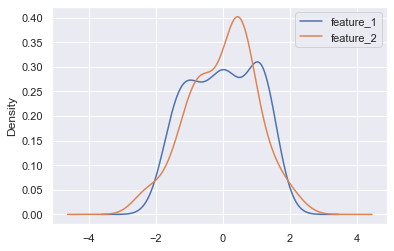

In [7]:
normalized_df.plot.density()

Definimos la función <b> dist </b> como la distancia ecluediana

In [8]:
def dist(row, centroid):
    return sum([(row[i] - centroid[i])**2 for i in range(0,len(row))])*1/2

Luego definimos los centroides iniciales. En esta primera instancia vamos a usar valores de feature_1 y feature_2 random dentro del rango que hay en el dataset

In [100]:
def generate_centroid(df):
    arr = []
    for column in df.columns:  #por cada feature
        arr.append(random.uniform(df[column].min(), df[column].max()))
    return arr ##centroide = [valor_f1, valor_f2]

In [243]:
def initialize(df, k):
    normalized_df=(df-df.mean())/df.std()
    df_expansion = normalized_df.copy()
    df_expansion['centroid'] = -1
    df_expansion['distance'] = float('inf')
    df_expansion['warn'] = 0
    centroids = [generate_centroid(normalized_df) for i in range(0, k)]
    return df_expansion, centroids

In [101]:
df_expansion.head(3)

,feature_1,feature_2,centroid,distance,warn
0,0.130330,2.106689,-1,inf,0
1,-1.229081,0.013947,-1,inf,0
2,0.718032,0.707252,-1,inf,0


In [244]:
def display(df, centroids, figsize=(7,6)):
    centroids_df = pd.DataFrame(centroids, columns=['feature_1', 'feature_2'])
    ax = df.plot.scatter(x='feature_1', y='feature_2', c='centroid', cmap='gist_rainbow', figsize=figsize)
    centroids_df.plot.scatter(x='feature_1', y='feature_2', ax=ax, c='black', s=200, marker='x')

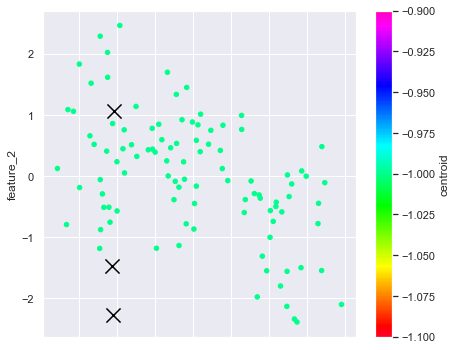

In [246]:
df_expansion, centroids = initialize(df, K)
display(df_expansion, centroids)

Comenzamos un proceso iterativo de 2 partes: <p>
    1. asignamos el centroide mas cercano a cada row <p>
    2. recalculamos los centroides como el promedio de los atributos de las rows en cada cluster

In [247]:
def assign_centroid(row, centroids): #colorearlos 
    min_distance = row['distance']
    min_centroid = row['centroid'].copy()
    warn = 0
    for i, c in enumerate(centroids):
        a = dist(row[:-3],c)
        if a < min_distance:
            min_distance = a
            min_centroid = i
            if min_centroid != row['centroid']:
                warn = 1
    return min_centroid, min_distance, warn

In [248]:
def calculate_centroid(df, centroid_n): 
    arr = []
    for c in df.columns[:-3]:
        arr.append(df.where(df.centroid == centroid_n)[c].mean()) 
    return arr

In [249]:
def calculate_centroids(df, k):
    arr = []
    for i in range(0, k):
        arr.append(calculate_centroid(df,i))
    return arr       

100.0


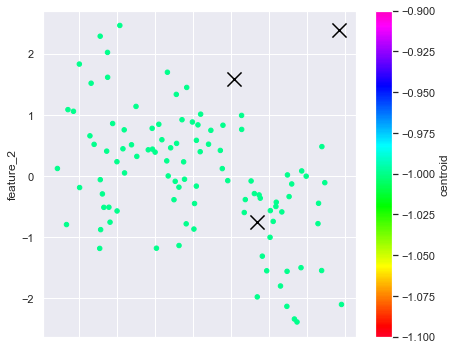

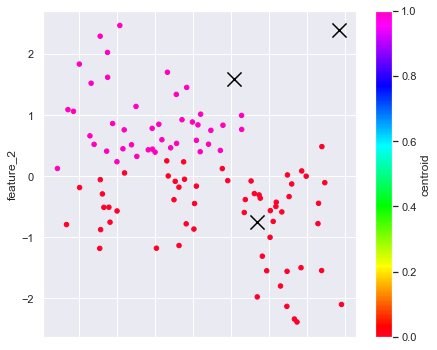

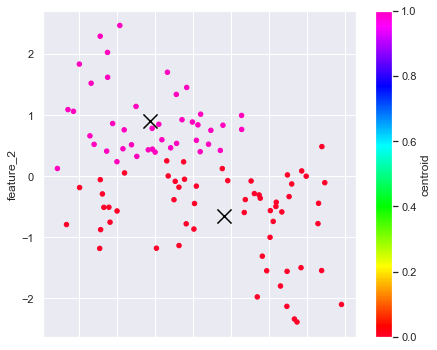

In [250]:
df_expansion, centroids = initialize(df, K)
display(df_expansion, centroids)
df_meta = df_expansion.apply(lambda row: pd.Series(assign_centroid(row, centroids),
                                               index=['centroid', 'distance', 'warn']), axis=1)
df_expansion.drop(columns=df_expansion.columns[-3:], axis=1, inplace=True)
df_expansion = df_expansion.join(df_meta)
display(df_expansion, centroids)
print(df_expansion.warn.sum())
centroids = calculate_centroids(df_expansion, K)
display(df_expansion, centroids)

In [132]:
df_expansion.head(5)

,feature_1,feature_2,centroid,distance,warn
0,0.130330,2.106689,0.0,0.232609,1.0
1,-1.229081,0.013947,2.0,0.184106,1.0
2,0.718032,0.707252,1.0,0.399559,1.0
3,-0.413841,1.174180,0.0,0.086975,1.0
4,-1.732814,-0.122336,2.0,0.336381,1.0


In [28]:
def iterate(df_expansion, centroids):
    ### coloreamos 
    df_meta = df_expansion.apply(lambda row: pd.Series(assign_centroid(row, centroids),
                                               index=['centroid', 'distance', 'warn']), axis=1)
    df_expansion.drop(columns=df_expansion.columns[-3:], axis=1, inplace=True)
    df_iter = df_expansion.join(df_meta)
    return df_iter, calculate_centroids(df_iter, len(centroids)) ##<- recalculamos centroide

In [29]:
def unnormalize_centroids(centroids, df):
    centroids_df = pd.DataFrame(centroids, columns=['feature_1', 'feature_2'])
    centroids_unnormalized = centroids_df*df.std() + df.mean()
    return centroids_unnormalized.values

In [148]:
def k_means(df, k, max_iter=50, log=False):
    df_expansion, centroids = initialize(df, k)
    for i in range(0, max_iter):
        df_expansion, centroids = iterate(df_expansion, centroids)
        i += 1
        if log:
            print('iteration: {}, reasigned_instances: {}'.format(i, df_expansion.warn.sum()))
        if df_expansion.warn.sum() == 0:
            break
    if i == max_iter:
        print('Warning: capped by max_iter = {}'.format(max_iter))
        
    clusters = df_expansion.centroid
    inercia = df_expansion.distance.sum()
    return clusters, unnormalize_centroids(centroids,df), inercia

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

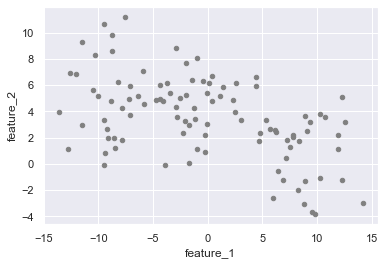

In [190]:
data, y = make_blobs(n_samples=100, n_features=2, centers=3, random_state=7, cluster_std=2.5)
df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df.plot.scatter(x='feature_1', y='feature_2', c='grey')

In [205]:
clusters,centroids, inertia = k_means(df, 3, max_iter=10, log=True)

iteration: 1, reasigned_instances: 100.0
iteration: 2, reasigned_instances: 26.0
iteration: 3, reasigned_instances: 3.0
iteration: 4, reasigned_instances: 1.0
iteration: 5, reasigned_instances: 1.0
iteration: 6, reasigned_instances: 1.0
iteration: 7, reasigned_instances: 0.0


In [202]:
inertia #suma de las distancias de todos los puntos a su centroide

55.008705366753745

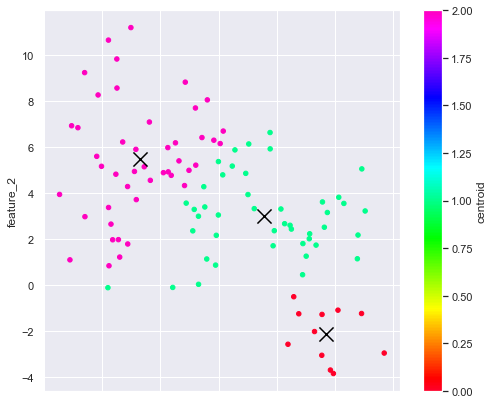

In [206]:
df_c = df.copy()
df_c['centroid'] = clusters
display(df_c, centroids, figsize=(8,7))

In [207]:
def k_means_with_tries(df, k, max_iter=50, tries=5, log=False):
    aux_inner = float('inf')
    aux_c = None,
    aux_cen = None
    for i in range (0,tries):
        clusters,centroids, innertia = k_means(df, k, max_iter, log=log)
        if(log):
            print('try {} with innertia: {} \n \n'.format(i, innertia))
        if aux_inner > innertia:
            aux_inner = innertia
            aux_c = clusters
            aux_cen = centroids
    return aux_c, aux_cen, aux_inner

In [208]:
clusters,centroids, innertia = k_means_with_tries(df, 3, log=True, tries=5)

iteration: 1, reasigned_instances: 100.0
iteration: 2, reasigned_instances: 5.0
iteration: 3, reasigned_instances: 3.0
iteration: 4, reasigned_instances: 1.0
iteration: 5, reasigned_instances: 1.0
iteration: 6, reasigned_instances: 0.0
try 0 with innertia: 33.860933133994266 
 

iteration: 1, reasigned_instances: 100.0
iteration: 2, reasigned_instances: 0.0
try 1 with innertia: 41.0381800632875 
 

iteration: 1, reasigned_instances: 100.0
iteration: 2, reasigned_instances: 13.0
iteration: 3, reasigned_instances: 3.0
iteration: 4, reasigned_instances: 1.0
iteration: 5, reasigned_instances: 1.0
iteration: 6, reasigned_instances: 0.0
try 2 with innertia: 24.61671719233871 
 

iteration: 1, reasigned_instances: 100.0
iteration: 2, reasigned_instances: 12.0
iteration: 3, reasigned_instances: 1.0
iteration: 4, reasigned_instances: 0.0
try 3 with innertia: 30.014109290496354 
 

iteration: 1, reasigned_instances: 100.0
iteration: 2, reasigned_instances: 5.0
iteration: 3, reasigned_instances: 

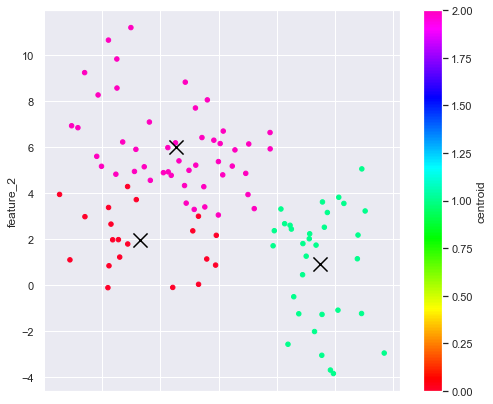

In [209]:
df_c = df.copy()
df_c['centroid'] = clusters
display(df_c, centroids, figsize=(8,7))

## KMEANS++

In [157]:
def calculate_distribution_weight(row, centroids):
    distance_to_centroids = [dist(row, c) for c in centroids]
    centroids_sum = sum([d**2 for d in distance_to_centroids])
    if( centroids_sum > 0):
        return min(distance_to_centroids)**2/centroids_sum
    else:
        return 0

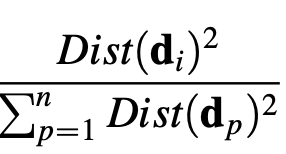

In [160]:
def select_next_centroid(df, centroids):
    aux_df = df.copy()
    aux_df['weights'] = df.apply(lambda row: calculate_distribution_weight(row, centroids), axis=1)
    aux_df['normalized_weights'] = aux_df.apply(lambda row: row.weights / aux_df.weights.sum(), axis=1)
    return df.iloc[[np.random.choice(df.index, p=aux_df.normalized_weights)]].values[0]

In [162]:
def select_initial_centroids(df, k):
    centroids = []
    centroids.append(df.iloc[[int(random.uniform(0, len(df)-1))]].values[0])
    for i in range(1,k):
        centroids.append(select_next_centroid(df, centroids))
    return centroids

In [168]:
def initialize(df, k, optimize_initial=True):
    normalized_df=(df-df.mean())/df.std()
    df_expansion = normalized_df.copy()
    df_expansion['centroid'] = -1
    df_expansion['distance'] = float('inf')
    df_expansion['warn'] = 0
    if optimize_initial: 
        centroids = select_initial_centroids(normalized_df, k)
    else:
        centroids = [generate_centroid(normalized_df) for i in range(0, k)]
    return df_expansion, centroids

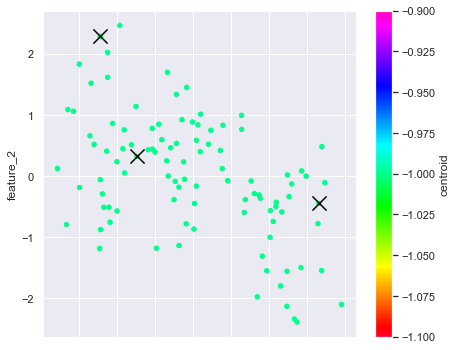

In [218]:
df_expansion, centroids = initialize(df, 3)
display(df_expansion, centroids)

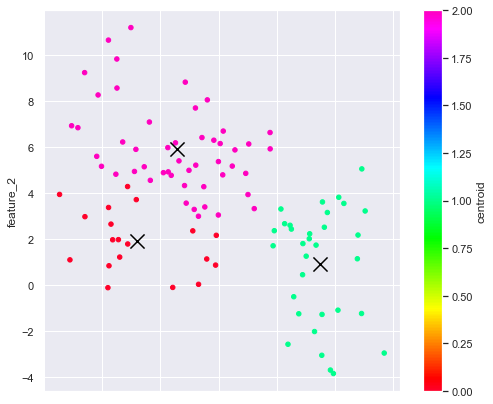

In [219]:
clusters,centroids, innertia = k_means_with_tries(df, 3, tries=5)
df_c = df.copy()
df_c['centroid'] = clusters
display(df_c, centroids, figsize=(8,7))

In [220]:
def elbow_method(df, k_means_method, min_k, max_k):
    inertias = []
    for i in range(min_k, max_k+1):
        _, _, inertia  = k_means_method(df, i)
        inertias.append(inertia)
    return inertias

In [216]:
elbow_inertias = elbow_method(df, k_means_with_tries, 1, 6)

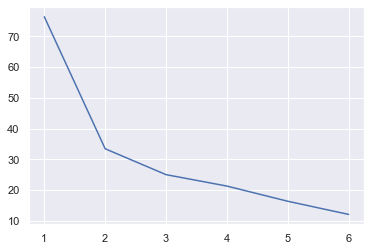

In [217]:
plt.plot(range(1, len(elbow_inertias)+1), elbow_inertias)

### SILHOUETE

In [221]:
def cluster_distance(row, cluster_df):
    cluster_df['distance'] = cluster_df.apply(lambda r: dist(r, row.values), axis=1)
    return cluster_df.distance.mean() ## la distancia promedio de un punto a los puntos de un cluster 


In [222]:
def make_distances(df_clusterized, k):
    aux_df = df_clusterized.copy()
    for i in range(0, k):
        aux_df['distance_{}'.format(i)] =  df_clusterized.apply(
            lambda row: cluster_distance(row, df_clusterized[df_clusterized.cluster==i]), axis=1)
    return aux_df

In [223]:
def calculate_silhouete(row, k):
    inner_distance = 0;
    inter_distance = float('inf')
    for i in range(0,k):
        if i == row.cluster:
            inner_distance = row['distance_{}'.format(i)]
        else:
            if (distance := row['distance_{}'.format(i)]) < inter_distance:
                inter_distance = distance
    return (inter_distance - inner_distance) / max(inter_distance, inner_distance)

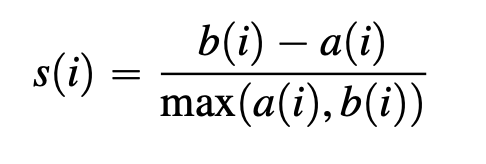

In [224]:
def make_silhouete(df, clusters, k):
    aux_df = df.copy()
    aux_df['cluster'] = clusters
    aux_df = make_distances(aux_df, k)
    aux_df['silhouete'] = aux_df.apply(lambda row: calculate_silhouete(row, k), axis=1)
    return aux_df

In [225]:
s_df = make_silhouete(df,clusters, 3)
s_df.head()

,feature_1,feature_2,cluster,distance_0,distance_1,distance_2,silhouete
0,-9.224319,2.648421,0.0,11.936209,168.059552,35.145656,0.660379
1,7.209092,0.441728,1.0,112.098851,7.175770,85.988141,0.916549
2,-10.330218,8.279551,2.0,37.052606,214.103245,37.335222,-0.007570
3,-8.476060,1.211565,0.0,10.526376,153.486206,36.970780,0.715278
4,6.135141,2.597803,1.0,96.570519,10.633465,65.438476,0.837504


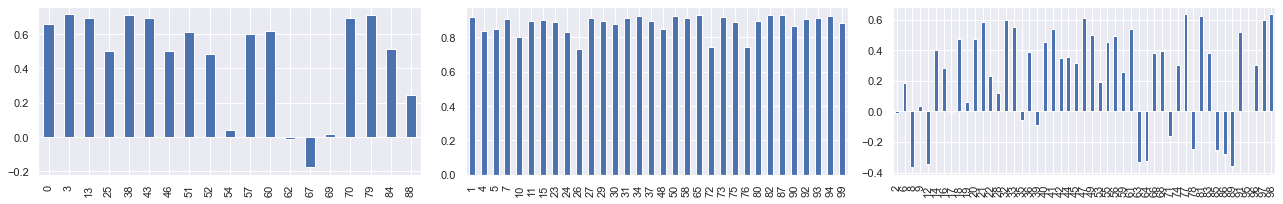

In [228]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(18,3))  # 1 row, 2 columns
s_df[s_df.cluster == 0].silhouete.plot.bar(ax=ax0)
s_df[s_df.cluster == 1].silhouete.plot.bar(ax=ax1)
s_df[s_df.cluster == 2].silhouete.plot.bar(ax=ax2)
plt.tight_layout()

In [229]:
s_df.silhouete.mean()

0.48411019564497143

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

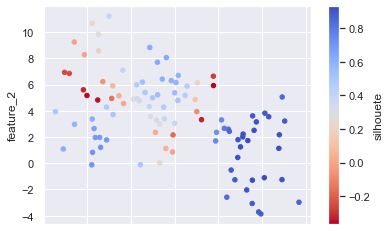

In [230]:
s_df.plot.scatter(x='feature_1', y='feature_2', c='silhouete', cmap='coolwarm_r')

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

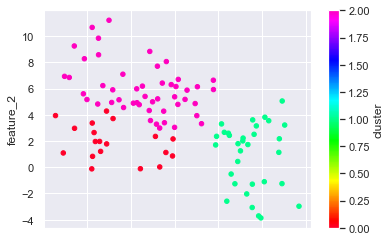

In [232]:
s_df.plot.scatter(x='feature_1', y='feature_2', c='cluster', cmap='gist_rainbow') 

In [233]:
def silhouete_evaluation_method(df, k_means_method, min_k, max_k):
    silhouetes = []
    for i in range(min_k, max_k+1):
        clusters, _ , _  = k_means_method(df, i)
        s_df = make_silhouete(df, clusters, i)
        silhouetes.append(s_df.silhouete.mean())
    return silhouetes

In [235]:
sil = silhouete_evaluation_method(df, k_means_with_tries, 2, 6)

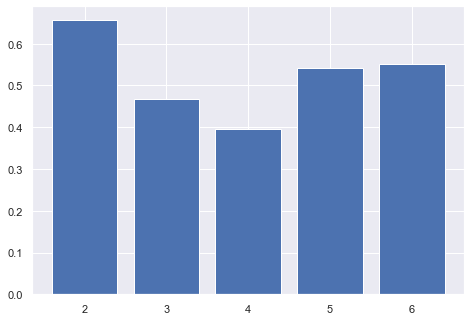

In [236]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = range(2,7)
y = sil
ax.bar(x,y)
plt.show()

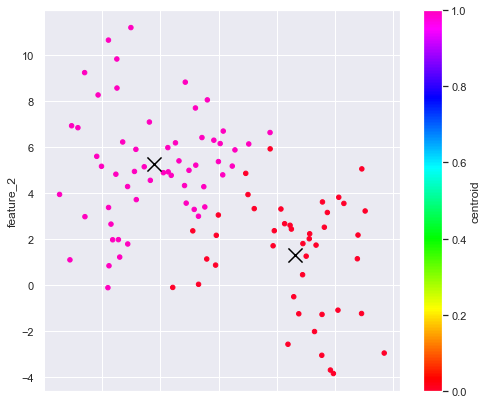

In [237]:
clusters,centroids, innertia = k_means_with_tries(df, 2, tries=10)
df_c = df.copy()
df_c['centroid'] = clusters
display(df_c, centroids, figsize=(8,7))

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

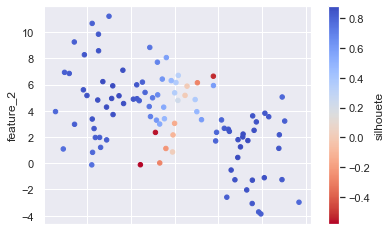

In [238]:
s_df = make_silhouete(df,clusters, 2)
s_df.plot.scatter(x='feature_1', y='feature_2', c='silhouete', cmap='coolwarm_r')

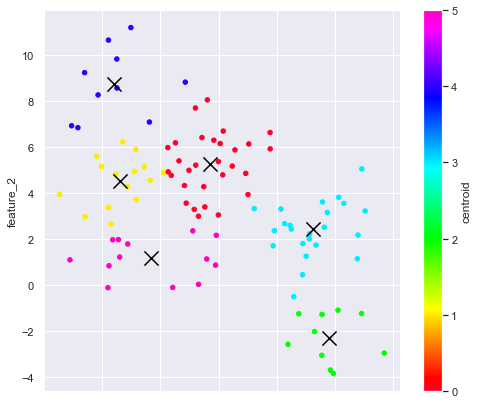

In [239]:
clusters,centroids, innertia = k_means_with_tries(df, 6, tries=10)
df_c = df.copy()
df_c['centroid'] = clusters
display(df_c, centroids, figsize=(8,7))

<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

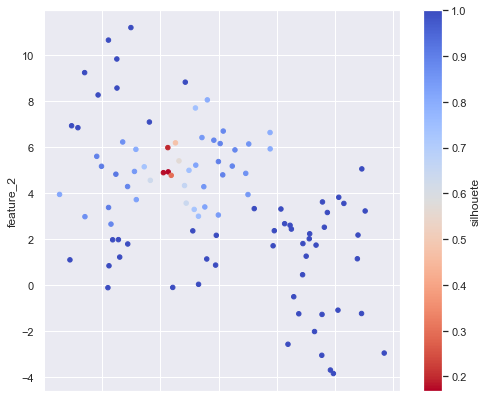

In [240]:
s_df = make_silhouete(df,clusters, 2)
s_df.plot.scatter(x='feature_1', y='feature_2', c='silhouete', cmap='coolwarm_r', figsize=(8,7))

In [242]:
s_df.silhouete.mean()

0.8929759849472483